# Imports

In [86]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import hvplot.pandas as hvplot
plt.style.use('seaborn')
!pip install ta
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)
import ta as ta
# Initial imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from pathlib import Path
import pandas as pd

In [144]:
def download(ticker):
# Note: We could have period < 60d and an intraday return
# Just change period to < 60 days and add interval = 1h
    df = yf.download(ticker, 
                period = '60d', # A period of 2 years from today
                prepost = False, # Pre and Post markets included
                threads = True, # Multi-thread processing for faster output.
                interval = '15m')
    return df
df = download("TSLA")
df = df[['Close','Open','High','Low','Volume']]
#data cleaning
print(df.describe())
print(df.isna().sum())


[*********************100%***********************]  1 of 1 completed
             Close         Open         High          Low        Volume
count  1557.000000  1557.000000  1557.000000  1557.000000  1.557000e+03
mean    728.165025   728.254538   731.480011   724.813785  1.261241e+06
std      81.773096    81.733569    81.335179    82.155198  1.038961e+06
min     546.710022   546.390015   562.619995   539.489990  0.000000e+00
25%     673.500000   673.880005   676.750000   670.500000  6.376800e+05
50%     701.989807   702.035522   704.769897   699.549988  9.563000e+05
75%     798.880005   799.032104   801.640015   796.200012  1.519822e+06
max     895.619995   895.599976   900.400024   888.504272  1.390479e+07
Close     0
Open      0
High      0
Low       0
Volume    0
dtype: int64


In [ ]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(data) - window):
        features = data.iloc[i : (i + window), :-1]
        target = data.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)
    # Define the window size
window_size = 32

# Set the index of the feature and target columns
feature_column = 3
target_column = 1

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(data, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

In [ ]:
data

### Getting a visual of the data

In [ ]:
# df = df['2019']
# temp = df.Close.pct_change()
# temp1 = temp.pct_change()
# comb = pd.concat([temp,temp1], axis = 'columns').rolling(200).mean()
# comb.columns = ['A','B']
# comb.plot(secondary_y = 'B')

In [ ]:
# # Another strategy.

# # If min is the same for x number of minutes, buy
# # If max is the same for x number of minues, sell.
# # df.Close.plot(figsize = (30,12))
# # low = df.Close.rolling(500).min()
# high = df.Close.rolling(100).max()
# volume = df.Volume.rolling(window = 100).mean()
# df[['Close','Volume']].rolling(window = 200).mean().plot(secondary_y = 'Volume')
# # short_low = low.rolling(window = 50).mean()
# # long_low = low.rolling(window = 100).mean()

# # # The lowest high of the last 50 time periods
# # lowest_high = high.rolling(window = 70).min()
# # # The highest high of the last 200 time periods.
# # highest_high = high.rolling(window = 200).max()

# # df[['Close','Volume']].plot(figsize = (20,15),
# #                                       secondary_y = 'Volume')
# # sma = df.Close.rolling(window = 75).mean() * 1.12
# # # sma1 = df.Close.rolling(window = 100).mean() * 0.95
# # low = df.Close.rolling(window = 200).min().rolling(window = 75).mean()
# # floor = df.Close.rolling(window = 150).min()

# # floor.plot()
# # low.plot()
# # sma.plot()
# # lowest_high.plot()
# # highest_hi
# # # When the 
# # lowest_high.plot()
# # highest_high.plot()







In [ ]:
# df.Close.plot(figsize = (30,15))

# upper = df.Close.rolling(50).mean() + df.Close.rolling(50).std() * 1
# lower = df.Close.rolling(50).mean() - df.Close.rolling(50).std() * 1
# middle = df.Close.rolling(50).mean()

# upper.plot()
# lower.plot()
# middle.plot()

In [ ]:
# start_day = str(df.index[0]).split(' ')[0]
# end_day = str(df.index[-1]).split(' ')[0]

# twenty_day_max = df.High.rolling(window = 5).max()
# # twenty_day_low = df.Low.rolling(window = 5).min()

# rolling_short = df.Close.rolling(window = 40).mean()
# rolling_long = df.Close.rolling(window = 160).mean()

# df.Close.plot(figsize = (30,10),
#              title = f'{ticker} Closing Prices from {start_day} to {end_day}', grid = True)
# # twenty_day_max.plot()
# # twenty_day_low.plot()
# rolling_short.plot()
# rolling_long.plot()

# NOTE: It would be cool for this graph to display VOLUME and their averages under this.

# Potential Buy Strategy.
### Buy when 10 up crosses 20 only if you don't have any stock already.
### Sell if actual stock price is less than X% of the X-day max price.

In [ ]:


df.Close.plot(figsize = (30,10))


In [ ]:
# Optional
#df = df.Close

### Changing the absolute values to percents

In [ ]:
close_price_change = df.pct_change()

# 2. Trading Strategies

* Create a strategy that does well in BULL markets.
* Create a strategy that does well in BEAR markets.
* Create charts for both visually showing entry end exit points.
* Figure out how much would be made with a buy and hold strategy
* Create a cumulative returns graph to display the difference

# This strategy does very well in markets that are more on the bear size.
### Meaning that the market doesn't have to be full bear, just at least mostly bear.

In [ ]:
df1 = df.copy()
# Set the short window and long windows
#40,80 works best so far.
short_sma = 40
long_sma = 80

In [ ]:
df1[f"{short_sma} SMA"] = df1.Close.rolling(short_sma).mean() 
df1[f"{long_sma} SMA"] = df1.Close.rolling(long_sma).mean() 

In [ ]:
df1.head(5)

The 1,-1 means that your are long when short sma > long sma, and short otherwise.

In [ ]:
df1['Position'] = np.where(df1[f'{short_sma} SMA'] > df1[f'{long_sma} SMA'],1,-1)

In [ ]:
df1['log_returns'] = np.log(df1['Close'] / df1['Close'].shift(1))

In [ ]:
df1['strategy_returns'] = df1.Position.shift(1) * df1['log_returns']

In [ ]:
df1.dropna(inplace = True)
df1.head()

#### Cumulative Sum

In [ ]:
df1[['log_returns','strategy_returns']].sum()
# Note that these give you the same ending value
# df1['log_returns'].cumsum()[-1]

In [ ]:
df1[['log_returns','strategy_returns']].sum().apply(np.exp) * 1000

In [ ]:
df1['BH CR'] = df1['log_returns'].cumsum().apply(np.exp) * 1000
df1['S CR'] = df1['strategy_returns'].cumsum().apply(np.exp) * 1000

df1[['BH CR','S CR']].plot()

In [ ]:
# exit = df[df['Position'] == -1.0]['Portfolio Total'].hvplot.scatter(
#     color='red',
#     legend=False,
#     ylabel='Total Portfolio Value',
#     width=1000,
#     height=400
# )

# # Visualize entry position relative to total portfolio value
# entry = df[df['Entry/Exit'] == 1.0]['Portfolio Total'].hvplot.scatter(
#     color='green',
#     legend=False,
#     ylabel='Total Portfolio Value',
#     width=1000,
#     height=400
# )

# # Visualize total portoflio value for the investment
# total_portfolio_value = df[['Portfolio Total']].hvplot(
#     line_color='lightgray',
#     ylabel='Total Portfolio Value',
#     width=1000,
#     height=400
# )

# # Overlay plots
# portfolio_entry_exit_plot = total_portfolio_value * entry * exit
# portfolio_entry_exit_plot.opts(xaxis=None)

In [ ]:
# df1['Signal'].value_counts()

In [ ]:
# df['Signal'].value_counts()

In [ ]:
# df['Entry/Exit'].value_counts()

# 3. Combining Trading Strategies

* Combine the strategies
* Figure out a trigger that allows the model to switch between strategies.
* Backtest the combined strategy
* Compare the cumulative returns of the buy and hold vs this strategy.

# 4. Predictive Model (Doesn't Work)
* Create a model that can predict future prices.
* Check to see if the model is over or underfit.
* Apply the combined strategy with the predicted values
* Backtest /forward test.
* Compare using a cumulative returns graph.

### Seeing which columns actually correlate.
Low correlation does not help the model.
Does high correlation actually do better?    

In [ ]:
# sns.set_style("darkgrid")
correlation = close_price_change.corr()

fig, ax = plt.subplots(figsize=(15,7.5))
ax.set_title('Correlation between OHLCV')
heat_map = sns.heatmap(data = correlation,
#                        x = correlation.Close,
                       annot=True,
                      ax = ax)
heat_map

## This is to help us easily see which columns have low correlation to Close
### So if you were to decide to put other data in the main dataframe, this would hopefully filter that out if it wasn't useful

In [ ]:
print('Correlations')
correlations = pd.DataFrame([correlation[x] for x in correlation][0])
print(correlations)

# Automatically keeping the high correlations
keepers = correlations[correlations.Close> 0.6]
keeper_columns = list(keepers.index)
print('\n\nHigh Correlations')
keeper_columns

### I would say to only keep High and Low

In [ ]:
# df1 = df1.loc[:,keeper_columns]
# df1 = df1[['Low','High','Close']]
# df1

### Separating the data into X and y

# THE PROBLEM WITH THIS MODEL
## It doesn't predict into the actual future. It only predicts things that have already happened. 
Pretty lame. I will try to get it to predict future values.

In [168]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [146]:
df

,Close,Open,High,Low,Volume
Datetime,,,,,
2021-01-25 09:30:00-05:00,875.261292,855.000000,875.489990,852.229980,3418610
2021-01-25 09:45:00-05:00,895.619995,876.000000,896.500000,874.330017,4060724
2021-01-25 10:00:00-05:00,888.635010,895.599976,900.400024,887.500000,3480491
2021-01-25 10:15:00-05:00,885.505005,888.510010,895.000000,885.200012,1544654
2021-01-25 10:30:00-05:00,878.830017,885.639587,887.599976,878.710022,1741634
...,...,...,...,...,...
2021-04-20 14:00:00-04:00,715.780090,718.170105,718.710022,714.960022,642908
2021-04-20 14:15:00-04:00,716.270020,715.650024,719.650024,715.099976,781932
2021-04-20 14:30:00-04:00,718.956909,716.304993,719.235596,714.919983,559735


In [169]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0 # Close
target_column = 0
X, y = window_data(df, window_size, feature_column, target_column)

In [149]:
split = int(0.80 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [150]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range= (0,1))
scaler = scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_scaler = scaler.fit(y)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [151]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [152]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [153]:
model = Sequential()
number_units = 20
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [154]:
model.compile(optimizer="adam", loss='mse', metrics = ['mse'])

In [155]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 10, 20)            1760      
_________________________________________________________________
dropout_28 (Dropout)         (None, 10, 20)            0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 10, 20)            3280      
_________________________________________________________________
dropout_29 (Dropout)         (None, 10, 20)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dropout_30 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [156]:
model.fit(X_train, y_train, epochs=2, shuffle=False, batch_size=1, verbose=1)

Epoch 1/2
1236/1236 [==============================] - 17s 9ms/step - loss: 0.0428 - mse: 0.0428
Epoch 2/2
1236/1236 [==============================] - 11s 9ms/step - loss: 0.0163 - mse: 0.0163


In [157]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 1s 5ms/step - loss: 0.0134 - mse: 0.0134


[0.01344364508986473, 0.01344364508986473]

In [158]:
predicted = model.predict(X_test)


In [159]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [160]:
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])

stocks.tail()

,Real,Predicted
Datetime,,
2021-04-20 14:00:00-04:00,718.304382,678.369263
2021-04-20 14:15:00-04:00,715.780090,678.352234
2021-04-20 14:30:00-04:00,716.270020,678.338196
2021-04-20 14:45:00-04:00,718.956909,678.317017
2021-04-20 14:59:03-04:00,716.340027,678.279236


<AxesSubplot:title={'center':"Aint worth shit. But damn. Ain't it pretty"}, xlabel='Datetime'>

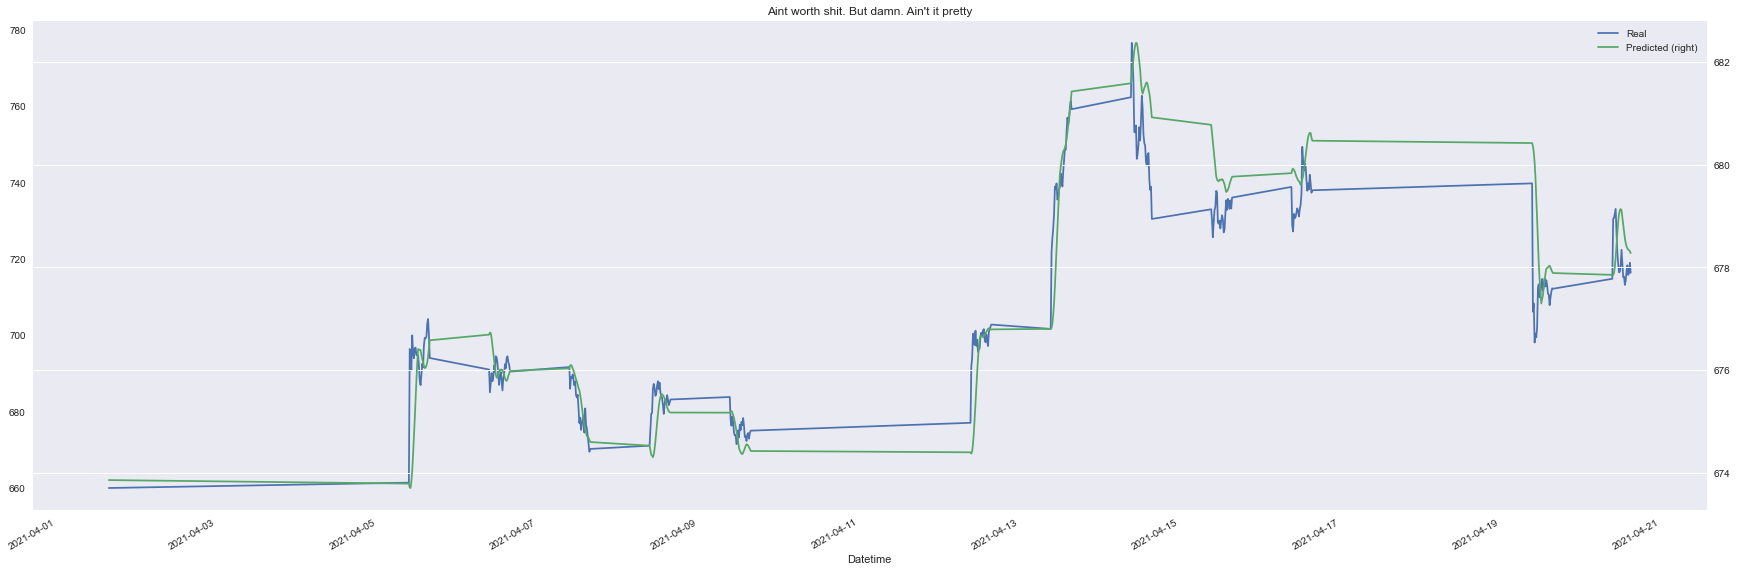

In [179]:
stocks.plot(title = "Aint worth shit. But damn. Ain't it pretty", figsize = (30, 10), secondary_y = 'Predicted')

In [162]:
df.reset_index(inplace = True)

In [164]:
df = df[['Datetime','Close']]
df.columns = ['Date','Close']
df.tail()

,Date,Close
1552,2021-04-20 14:00:00-04:00,715.780090
1553,2021-04-20 14:15:00-04:00,716.270020
1554,2021-04-20 14:30:00-04:00,718.956909
1555,2021-04-20 14:45:00-04:00,716.340027
1556,2021-04-20 14:59:03-04:00,716.299988


In [165]:

close_data = df.Close.values.reshape((-1))
look_back = 10
def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
       
        out = model.predict(x)
        output=scaler.inverse_transform(out)
        prediction_list = np.append(prediction_list, output)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    


num_prediction = 2
forecast = predict(num_prediction, model)


In [166]:
prediction = pd.DataFrame({"Prediction":forecast} )
prediction

,Prediction
0,716.299988
1,683.709045
2,683.709045


In [167]:
prediction.set_index('Date', inplace = True)

KeyError: "None of ['Date'] are in the columns"

In [ ]:
df.set_index('Date', inplace = True)

# 5. Conclusions
* How did our model do compared to a buy and hold strategy?
    * Buy how much did or didn't it suck.
    * Cumulative returns
    * Risk
    * Number of trades
    * Number of gains / (Number of gains + Number of losses)
    * ## Anything else you guys think would help in the comparison.

# Notes to eventually add to the conclusion.

We learned that using a neural network model to predict stocks is pretty naive. That doesn't seem to be their strong point. They can predict "future" prices so long as they have "future" prices to learn from. The closest I found of someone using them to actually predict future prices was a couple of people who could predict prices one day out. Now if you kept doing this, this model might be of some use. However, I couldn't get that figured out.

In [ ]:
len(df.columns)